# Predicting Risk of Breast Cancer Relapse from CNA

## Imports

In [1]:
import pandas as pd 
import numpy as np
import pybedtools
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import sklearn
from sklearn.preprocessing import *
from sklearn.feature_selection import *
from sklearn.model_selection import *
from sklearn.svm import *
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *
from scipy import interp
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

## Load METABRIC clinical file

In [2]:
metabric_clinical = pd.read_csv('clinical_METABRIC.tsv', sep='\t')
print("Original Shape: ", metabric_clinical.shape)
metabric_clinical = metabric_clinical.loc[(metabric_clinical['ER.Expr'] == '+') & (metabric_clinical['Her2.Expr'] == '-')]
print("Only ER+/HER2-: ", metabric_clinical.shape)
metabric_clinical = metabric_clinical[metabric_clinical.iC10.apply(lambda x: x in ['3','4ER+','7','8','1','2','6','9'])]
metabric_clinical = metabric_clinical.loc[metabric_clinical['Size'] == metabric_clinical['Size']]
metabric_clinical = metabric_clinical.loc[metabric_clinical['Grade'] == metabric_clinical['Grade']]
label = []
for index,row in metabric_clinical.iterrows():
    if row['iC10'] in ['3','4ER+','7','8']:
        label.append(0)
    elif row['iC10'] in ['1','2','6','9']:
        label.append(1)
metabric_clinical['label'] = label
#metabric_clinical = metabric_clinical.loc[(metabric_clinical['T'] > 1825) & (metabric_clinical['TDR'] > 1825)]
metabric_clinical['DeathBreast'] = metabric_clinical['DeathBreast'].astype('bool')
metabric_clinical['Lymph.Nodes.Positive'] = metabric_clinical['Lymph.Nodes.Positive'].astype('float')
metabric_clinical['LR'] = metabric_clinical['LR'].astype('bool')
metabric_clinical['DR'] = metabric_clinical['DR'].astype('bool')
metabric_clinical['TLDR'] = metabric_clinical[['TLR','TDR']].min(axis=1)
metabric_clinical['LDR'] = (metabric_clinical['LR'] | metabric_clinical['DR']).astype('bool')
metabric_clinical['TDLR'] = metabric_clinical[['T','TLR']].min(axis=1)
metabric_clinical['DLR'] = (metabric_clinical['DeathBreast'] | metabric_clinical['LR']).astype('bool')
metabric_clinical['TDDR'] = metabric_clinical[['T','TDR']].min(axis=1)
metabric_clinical['DDR'] = (metabric_clinical['DeathBreast'] | metabric_clinical['DR']).astype('bool')
metabric_clinical['TDLDR'] = metabric_clinical[['T','TLR','TDR']].min(axis=1)
metabric_clinical['DLDR'] = (metabric_clinical['DeathBreast'] | metabric_clinical['DR'] | metabric_clinical['LR']).astype('bool')

metabric_clinical.drop_duplicates(inplace=True)

print("Only ER+/HER2- in 8 IntClusts: ", metabric_clinical.shape)
display(metabric_clinical.head())

Original Shape:  (1980, 35)
Only ER+/HER2-:  (1398, 35)
Only ER+/HER2- in 8 IntClusts:  (1285, 44)


,METABRIC.ID,MATCHED.NORMAL.METABRIC.ID,Cohort,Age.At.Diagnosis,Breast.Tumour.Laterality,Date.Of.Diagnosis,Last.Followup.Status,NPI,ER.Status,Inferred.Menopausal.State,...,Complete.Rec.History,label,TLDR,LDR,TDLR,DLR,TDDR,DDR,TDLDR,DLDR
0,MB-0002,MB-0003,1,43.19,r,2000/12,a,4.020,pos,pre,...,YES,0,2539,False,2539,False,2539,False,2539,False
1,MB-0005,MB-0004,1,48.87,r,2001/02,d-d.s.,4.030,pos,pre,...,YES,0,4599,True,4911,True,4599,True,4599,True
2,MB-0006,MB-0007,1,47.68,r,2001/02,a,4.050,pos,pre,...,YES,1,4948,False,4948,False,4948,False,4948,False
3,MB-0010,MB-0011,1,78.77,l,2001/03,d-d.s.,4.062,pos,post,...,YES,0,88,True,234,True,88,True,88,True
4,MB-0014,MB-0015,1,56.45,r,2001/04,a,4.020,pos,post,...,YES,0,4930,False,4930,False,4930,False,4930,False


## Survival Analysis

### Cumulative Incidence Curves by Event Type

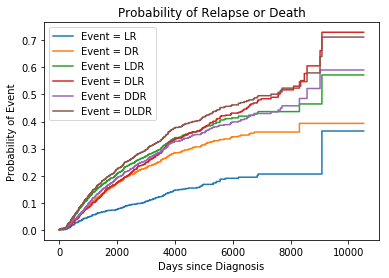

In [3]:
for event in ('LR','DR','LDR','DLR','DDR','DLDR'):
    time_index = 'T' + event
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical[event],
        metabric_clinical[time_index])
    
    plt.step(time, 1 - survival_prob, where="post",
             label="Event = %s" % event)

plt.ylabel("Probability of Event")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of Relapse or Death")
plt.legend(loc="best")

### Cumulative Incidence Curves by IntClust Subtypes

### Distant Relapse (DR)

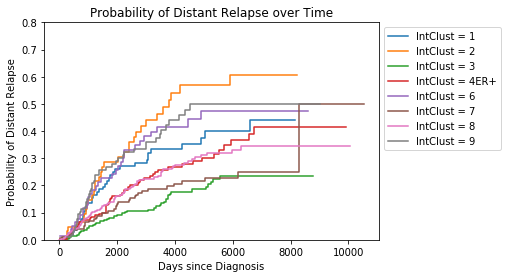

In [38]:
for risk_type in ('1','2','3','4ER+','6','7','8','9'):
    mask_risk = metabric_clinical['iC10'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['DR'][mask_risk],
        metabric_clinical['TDR'][mask_risk])
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Probability of Distant Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of Distant Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1))

### Local Relapse (LR)

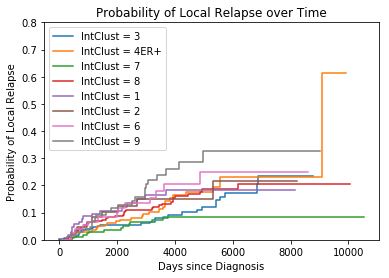

In [5]:
for risk_type in ('1','2','3','4ER+','6','7','8','9'):
    mask_risk = metabric_clinical['iC10'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['LR'][mask_risk],
        metabric_clinical['TLR'][mask_risk])
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Probability of Local Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of Local Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

### Disease Specific Death (DSD)

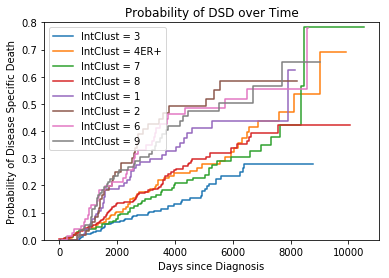

In [6]:
for risk_type in ('1','2','3','4ER+','6','7','8','9'):
    mask_risk = metabric_clinical['iC10'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['DeathBreast'][mask_risk],
        metabric_clinical['T'][mask_risk])
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Probability of Disease Specific Death")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

### Local or Distant Relapse (LDR)

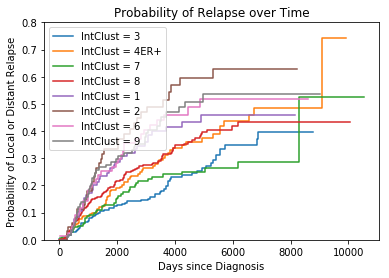

In [7]:
for risk_type in ('1','2','3','4ER+','6','7','8','9'):
    mask_risk = metabric_clinical['iC10'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['LDR'][mask_risk],
        metabric_clinical['TLDR'][mask_risk])
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Probability of Local or Distant Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

### Disease Specific Death or Distant Relapse (DDR)

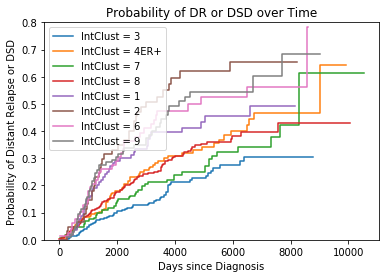

In [8]:
for risk_type in ('1','2','3','4ER+','6','7','8','9'):
    mask_risk = metabric_clinical['iC10'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['DDR'][mask_risk],
        metabric_clinical['TDDR'][mask_risk])
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Probability of Distant Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of DR or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

### Disease Specific Death or Local Relapse (DLR)

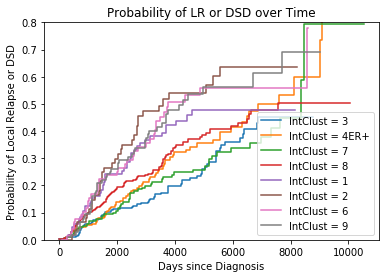

In [9]:
for risk_type in ('1','2','3','4ER+','6','7','8','9'):
    mask_risk = metabric_clinical['iC10'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['DLR'][mask_risk],
        metabric_clinical['TDLR'][mask_risk])
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Probability of Local Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of LR or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

### Disease Specific Death or Local or Distant Relapse (DLDR)

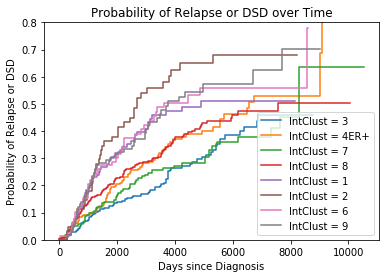

In [10]:
for risk_type in ('1','2','3','4ER+','6','7','8','9'):
    mask_risk = metabric_clinical['iC10'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['DLDR'][mask_risk],
        metabric_clinical['TDLDR'][mask_risk])
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Probability of Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of Relapse or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

### Cumulative Incidence Curves by IntClust Label

### Distant Relapse (DR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         45.75 <0.005     36.12


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2326.99811, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 931 censored>
      duration col = 'TDR'
         event col = 'DR'
number of subjects = 1285
  number of events = 354
partial log-likelihood = -2327.00
  time fit was run = 2019-06-11 22:14:10 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
label                 0.50      1.64      0.12 4.17 <0.005     15.03        0.26        0.73
Age.At.Diagnosis      0.00      1.00      0.00 0.58   0.56      0.83       -0.01        0.01
Size                  0.02      1.02      0.00 7.01 <0.005     38.61        0.01        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01 6.89 <0.005     37.38        0.04        0.07
Grade                 0.17      1.18      0.09 1.86   0.06      3.98       -0.01        0.35
---
Concordance =

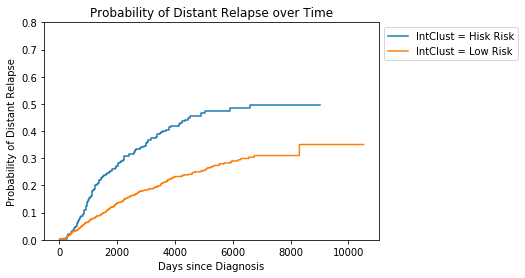

In [44]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = metabric_clinical['label'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['DR'][mask_risk],
        metabric_clinical['TDR'][mask_risk])
    risk_[risk_type] = metabric_clinical['DR'][mask_risk]
    time_[risk_type] = metabric_clinical['TDR'][mask_risk]
    
    leg = ""
    
    if risk_type:
        leg = "Hisk Risk"
    else:
        leg = "Low Risk"
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % leg)

plt.ylabel("Probability of Distant Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of Distant Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1))

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
cph.fit(metabric_clinical[['label','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DR','TDR']], duration_col='TDR', event_col='DR', show_progress=True)
cph.print_summary()

### Local Relapse (LR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         10.20 <0.005      9.47


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -1119.70566, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 1115 censored>
      duration col = 'TLR'
         event col = 'LR'
number of subjects = 1285
  number of events = 170
partial log-likelihood = -1119.71
  time fit was run = 2019-06-11 18:37:08 UTC

---
                      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
label                 0.38      1.46      0.18  2.14   0.03      4.96        0.03        0.72
Age.At.Diagnosis     -0.03      0.97      0.01 -3.95 <0.005     13.63       -0.04       -0.01
Size                  0.01      1.01      0.00  1.17   0.24      2.05       -0.00        0.01
Lymph.Nodes.Positive  0.05      1.06      0.01  4.05 <0.005     14.26        0.03        0.08
Grade                 0.13      1.13      0.13  0.98   0.33      1.61       -0.13        0.38
---
Concor

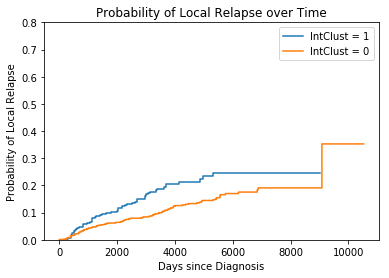

In [12]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = metabric_clinical['label'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['LR'][mask_risk],
        metabric_clinical['TLR'][mask_risk])
    risk_[risk_type] = metabric_clinical['LR'][mask_risk]
    time_[risk_type] = metabric_clinical['TLR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Probability of Local Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of Local Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
cph.fit(metabric_clinical[['label','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','LR','TLR']], duration_col='TLR', event_col='LR', show_progress=True)
cph.print_summary()

### Disease Specific Death (DSD)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         49.38 <0.005     38.79


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2378.51343, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 912 censored>
      duration col = 'T'
         event col = 'DeathBreast'
number of subjects = 1285
  number of events = 373
partial log-likelihood = -2378.51
  time fit was run = 2019-06-11 18:37:09 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
label                 0.45      1.57      0.12 3.89 <0.005     13.25        0.22        0.68
Age.At.Diagnosis      0.02      1.02      0.00 3.96 <0.005     13.69        0.01        0.03
Size                  0.01      1.01      0.00 6.48 <0.005     33.30        0.01        0.02
Lymph.Nodes.Positive  0.05      1.05      0.01 6.67 <0.005     35.15        0.04        0.07
Grade                 0.27      1.31      0.09 2.96 <0.005      8.32        0.09        0.44
---
Concor

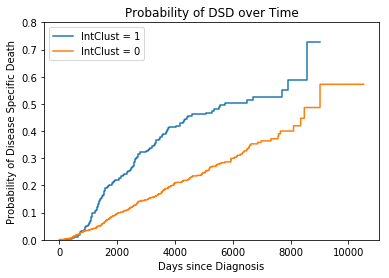

In [13]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = metabric_clinical['label'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['DeathBreast'][mask_risk],
        metabric_clinical['T'][mask_risk])
    risk_[risk_type] = metabric_clinical['DeathBreast'][mask_risk]
    time_[risk_type] = metabric_clinical['T'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Probability of Disease Specific Death")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
cph.fit(metabric_clinical[['label','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DeathBreast','T']], duration_col='T', event_col='DeathBreast', show_progress=True)
cph.print_summary()

### Local or Distant Relapse (LDR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         32.65 <0.005     26.43


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2798.41648, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 860 censored>
      duration col = 'TLDR'
         event col = 'LDR'
number of subjects = 1285
  number of events = 425
partial log-likelihood = -2798.42
  time fit was run = 2019-06-11 18:37:09 UTC

---
                      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
label                 0.39      1.48      0.11  3.54 <0.005     11.29        0.17        0.61
Age.At.Diagnosis     -0.01      0.99      0.00 -1.52   0.13      2.97       -0.01        0.00
Size                  0.01      1.01      0.00  5.60 <0.005     25.50        0.01        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01  6.73 <0.005     35.79        0.04        0.07
Grade                 0.13      1.14      0.08  1.60   0.11      3.19       -0.03        0.29
---
Conco

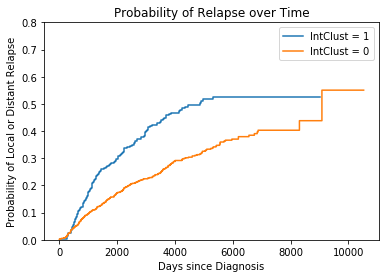

In [14]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = metabric_clinical['label'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['LDR'][mask_risk],
        metabric_clinical['TLDR'][mask_risk])
    risk_[risk_type] = metabric_clinical['LDR'][mask_risk]
    time_[risk_type] = metabric_clinical['TLDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Probability of Local or Distant Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
cph.fit(metabric_clinical[['label','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','LDR','TLDR']], duration_col='TLDR', event_col='LDR', show_progress=True)
cph.print_summary()

### Disease Specific Death or Distant Relapse (DDR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         51.59 <0.005     40.41


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2766.01254, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 859 censored>
      duration col = 'TDDR'
         event col = 'DDR'
number of subjects = 1285
  number of events = 426
partial log-likelihood = -2766.01
  time fit was run = 2019-06-11 18:37:10 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
label                 0.47      1.61      0.11 4.37 <0.005     16.32        0.26        0.69
Age.At.Diagnosis      0.01      1.01      0.00 2.33   0.02      5.65        0.00        0.02
Size                  0.02      1.02      0.00 7.64 <0.005     45.39        0.01        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01 7.42 <0.005     42.99        0.04        0.07
Grade                 0.18      1.20      0.08 2.15   0.03      4.99        0.02        0.34
---
Concordance

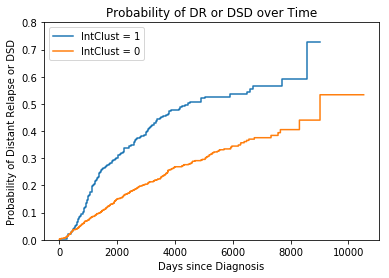

In [15]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = metabric_clinical['label'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['DDR'][mask_risk],
        metabric_clinical['TDDR'][mask_risk])
    risk_[risk_type] = metabric_clinical['DDR'][mask_risk]
    time_[risk_type] = metabric_clinical['TDDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Probability of Distant Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of DR or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
cph.fit(metabric_clinical[['label','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DDR','TDDR']], duration_col='TDDR', event_col='DDR', show_progress=True)
cph.print_summary()

### Disease Specific Death or Local Relapse (DLR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         36.98 <0.005     29.64


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2911.66858, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 834 censored>
      duration col = 'TDLR'
         event col = 'DLR'
number of subjects = 1285
  number of events = 451
partial log-likelihood = -2911.67
  time fit was run = 2019-06-11 18:37:10 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
label                 0.38      1.47      0.11 3.58 <0.005     11.48        0.17        0.59
Age.At.Diagnosis      0.00      1.00      0.00 0.93   0.35      1.51       -0.00        0.01
Size                  0.01      1.01      0.00 5.16 <0.005     21.91        0.01        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01 6.77 <0.005     36.23        0.04        0.07
Grade                 0.18      1.20      0.08 2.23   0.03      5.29        0.02        0.34
---
Concordance

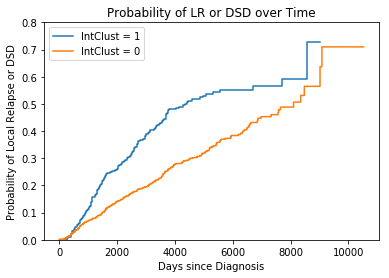

In [16]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = metabric_clinical['label'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['DLR'][mask_risk],
        metabric_clinical['TDLR'][mask_risk])
    risk_[risk_type] = metabric_clinical['DLR'][mask_risk]
    time_[risk_type] = metabric_clinical['TDLR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Probability of Local Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of LR or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
cph.fit(metabric_clinical[['label','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DLR','TDLR']], duration_col='TDLR', event_col='DLR', show_progress=True)
cph.print_summary()

### Disease Specific Death or Local or Distant Relapse (DLDR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         37.70 <0.005     30.17


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -3194.42112, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 795 censored>
      duration col = 'TDLDR'
         event col = 'DLDR'
number of subjects = 1285
  number of events = 490
partial log-likelihood = -3194.42
  time fit was run = 2019-06-11 18:37:10 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
label                 0.39      1.48      0.10 3.79 <0.005     12.68        0.19        0.59
Age.At.Diagnosis      0.00      1.00      0.00 0.00   1.00      0.01       -0.01        0.01
Size                  0.01      1.01      0.00 6.10 <0.005     29.83        0.01        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01 7.17 <0.005     40.29        0.04        0.07
Grade                 0.14      1.15      0.08 1.79   0.07      3.77       -0.01        0.29
---
Concordan

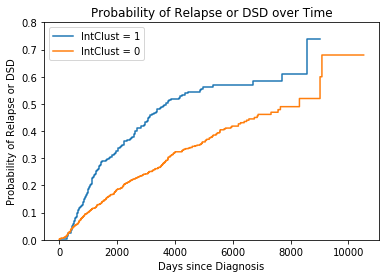

In [17]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = metabric_clinical['label'] == risk_type
    time, survival_prob = kaplan_meier_estimator(
        metabric_clinical['DLDR'][mask_risk],
        metabric_clinical['TDLDR'][mask_risk])
    risk_[risk_type] = metabric_clinical['DLDR'][mask_risk]
    time_[risk_type] = metabric_clinical['TDLDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Probability of Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Probability of Relapse or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
cph.fit(metabric_clinical[['label','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DLDR','TDLDR']], duration_col='TDLDR', event_col='DLDR', show_progress=True)
cph.print_summary()

## Measuring C-Index

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

clinical_X = metabric_clinical[['label','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DR','TDR']]

preds = np.zeros(clinical_X.shape[0])

f = 0
for train_index, test_index in cv.split(clinical_X, metabric_clinical['label']):
    X_train, X_test = clinical_X.iloc[train_index], clinical_X.iloc[test_index]
    X_test = X_test.drop('DR', axis=1)
    X_test = X_test.drop('TDR', axis=1)
    cph = CoxPHFitter()
    cph.fit(X_train, duration_col='TDR', event_col='DR')
    fold_preds = cph.predict_expectation(X_test)
    
    for i,j in zip(test_index,range(len(fold_preds))):
        preds[i] = fold_preds.iloc[j,0]
    
    f += 1
    print("Fold: \t", f)
    
c_index = concordance_index(clinical_X['TDR'], preds, clinical_X['DR'])
print(c_index)

Fold: 	 1
Fold: 	 2
Fold: 	 3
Fold: 	 4
Fold: 	 5
0.6755565607540619


## Class Imbalance

### IntClust Label Proportions

In [19]:
print("Negative Examples: ", len(metabric_clinical.loc[metabric_clinical['label'] == 0]))
print("Positive Examples: ", len(metabric_clinical.loc[metabric_clinical['label'] == 1]))

Negative Examples:  925
Positive Examples:  360


### Clinical Label Proportions

In [21]:
print("Non-DR Examples: ", len(metabric_clinical.loc[metabric_clinical['DR'] == 0]))
print("DR Examples: ", len(metabric_clinical.loc[metabric_clinical['DR'] == 1]))

Non-DR Examples:  931
DR Examples:  354


In [20]:
print("Non-LR Examples: ", len(metabric_clinical.loc[metabric_clinical['LR'] == 0]))
print("LR Examples: ", len(metabric_clinical.loc[metabric_clinical['LR'] == 1]))

Non-LR Examples:  1115
LR Examples:  170


In [22]:
print("Non-DSD Examples: ", len(metabric_clinical.loc[metabric_clinical['DeathBreast'] == 0]))
print("DSD Examples: ", len(metabric_clinical.loc[metabric_clinical['DeathBreast'] == 1]))

Non-DSD Examples:  912
DSD Examples:  373


In [23]:
print("Non-LDR Examples: ", len(metabric_clinical.loc[metabric_clinical['LDR'] == 0]))
print("DLR Examples: ", len(metabric_clinical.loc[metabric_clinical['LDR'] == 1]))

Non-LDR Examples:  860
DLR Examples:  425


In [25]:
print("Non-DDR Examples: ", len(metabric_clinical.loc[metabric_clinical['DDR'] == 0]))
print("DDR Examples: ", len(metabric_clinical.loc[metabric_clinical['DDR'] == 1]))

Non-DDR Examples:  859
DDR Examples:  426


In [24]:
print("Non-DLR Examples: ", len(metabric_clinical.loc[metabric_clinical['DLR'] == 0]))
print("DLR Examples: ", len(metabric_clinical.loc[metabric_clinical['DLR'] == 1]))

Non-DLR Examples:  834
DLR Examples:  451


In [26]:
print("Non-DLDR Examples: ", len(metabric_clinical.loc[metabric_clinical['DLDR'] == 0]))
print("DLDR Examples: ", len(metabric_clinical.loc[metabric_clinical['DLDR'] == 1]))

Non-DLDR Examples:  795
DLDR Examples:  490


## Load CNA data

### Load segmented CNA file

In [27]:
metabric_iclust = pd.read_csv('CNA_0.005eps_metabric.tsv', sep='\t')
metabric_iclust.rename(columns={metabric_iclust.columns[0]: 'sample'}, inplace=True)
display(metabric_iclust.head())
display(metabric_iclust.shape)

,sample,chr1.51599-72034,chr1.72034-75800,chr1.75800-88452,chr1.88452-88466,chr1.88466-218570,chr1.218570-218593,chr1.218593-218939,chr1.218939-219037,chr1.219037-219483,...,chr22.41285376-41285697,chr22.41285697-43029372,chr22.43029372-43032379,chr22.43032379-45779329,chr22.45779329-45780363,chr22.45780363-45780734,chr22.45780734-47538878,chr22.47538878-49319975,chr22.49319975-49320621,chr22.49320621-49581322
0,MB-0000,-0.112070,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,...,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073
1,MB-0002,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,...,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810
2,MB-0005,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,...,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826
3,MB-0006,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,...,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061
4,MB-0008,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,...,-0.361051,-0.274476,-0.122731,-0.274476,-0.274476,-0.274476,-0.274476,-0.274476,-0.055292,-0.055292


(1360, 4795)

### Merge CNA and clinical tables

In [28]:
metabric_iclust_joined = metabric_iclust.merge(metabric_clinical, how='inner', left_on='sample', right_on='METABRIC.ID')#right_on="ID")
metabric_iclust_joined = metabric_iclust_joined.drop('METABRIC.ID', axis=1)
display(metabric_iclust_joined.head())
display(metabric_iclust_joined.shape)

,sample,chr1.51599-72034,chr1.72034-75800,chr1.75800-88452,chr1.88452-88466,chr1.88466-218570,chr1.218570-218593,chr1.218593-218939,chr1.218939-219037,chr1.219037-219483,...,Complete.Rec.History,label,TLDR,LDR,TDLR,DLR,TDDR,DDR,TDLDR,DLDR
0,MB-0000,-0.112070,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,...,YES,0,4215,False,4215,False,4215,False,4215,False
1,MB-0002,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,...,YES,0,2539,False,2539,False,2539,False,2539,False
2,MB-0005,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,...,YES,0,4599,True,4911,True,4599,True,4599,True
3,MB-0006,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,...,YES,1,4948,False,4948,False,4948,False,4948,False
4,MB-0008,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,...,YES,1,564,True,564,True,941,True,564,True


(1285, 4838)

## Prepare for Model Training

### Extract Features

In [29]:
pd.set_option('display.max_columns', 50)
metabric_iclust_joined = metabric_iclust_joined.loc[metabric_iclust_joined['Size'] == metabric_iclust_joined['Size']]
metabric_iclust_joined = metabric_iclust_joined.loc[metabric_iclust_joined['Grade'] == metabric_iclust_joined['Grade']]
X = metabric_iclust_joined.drop('label', axis=1)
X = X.drop('sample', axis=1)
X = X.iloc[:,:4794]
X['Age.At.Diagnosis'] = metabric_iclust_joined['Age.At.Diagnosis']
X['Size'] = metabric_iclust_joined['Size']
X['Grade'] = metabric_iclust_joined['Grade']
X['Lymph.Nodes.Positive']  = metabric_iclust_joined['Lymph.Nodes.Positive']
display(X.shape)
display(X.head())

(1285, 4798)

,chr1.51599-72034,chr1.72034-75800,chr1.75800-88452,chr1.88452-88466,chr1.88466-218570,chr1.218570-218593,chr1.218593-218939,chr1.218939-219037,chr1.219037-219483,chr1.219483-219541,chr1.219541-225534,chr1.225534-225802,chr1.225802-346307,chr1.346307-394035,chr1.394035-524415,chr1.524415-593454,chr1.593454-1617779,chr1.1617779-1618687,chr1.1618687-1631964,chr1.1631964-1677448,chr1.1677448-12761332,chr1.12761332-12764516,chr1.12764516-12780450,chr1.12780450-12781880,chr1.12781880-12784829,...,chr22.37719575-37719652,chr22.37719652-37724341,chr22.37724341-37725229,chr22.37725229-37729259,chr22.37729259-37733740,chr22.37733740-38924519,chr22.38924519-38930433,chr22.38930433-41227227,chr22.41227227-41229385,chr22.41229385-41272907,chr22.41272907-41285376,chr22.41285376-41285697,chr22.41285697-43029372,chr22.43029372-43032379,chr22.43032379-45779329,chr22.45779329-45780363,chr22.45780363-45780734,chr22.45780734-47538878,chr22.47538878-49319975,chr22.49319975-49320621,chr22.49320621-49581322,Age.At.Diagnosis,Size,Grade,Lymph.Nodes.Positive
0,-0.112070,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.004068,0.004068,0.004068,-0.050073,-0.050073,-0.050073,-0.050073,-0.112070,-0.050073,0.112400,0.112400,0.112400,...,-0.112070,-0.112070,-0.112070,-0.112070,-0.112070,-0.112070,-0.112070,-0.112070,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,75.65,22.0,3.0,10.0
1,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.060700,0.002596,0.002596,0.002596,0.002596,...,-0.189274,-0.189274,0.612394,0.612394,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,43.19,10.0,3.0,0.0
2,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,...,-0.041826,-0.041826,0.484979,0.484979,0.484979,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,48.87,15.0,2.0,1.0
3,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,...,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,47.68,25.0,2.0,3.0
4,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,-0.274476,-0.437599,-0.437599,-0.437599,-0.274476,-0.361051,-0.361051,0.020861,0.020861,...,0.091105,0.091105,0.091105,0.091105,0.091105,-0.274476,-0.437599,-0.437599,-0.361051,-0.361051,-0.361051,-0.361051,-0.274476,-0.122731,-0.274476,-0.274476,-0.274476,-0.274476,-0.274476,-0.055292,-0.055292,76.97,40.0,3.0,8.0


### Extract Targets

In [30]:
Y = metabric_iclust_joined.iloc[:,4795:]
# Y['DR'] = Y['DR'].astype(int)
# Y['DDR'] = Y['DDR'].astype(int)
display(Y.head())
display(Y.shape)

,MATCHED.NORMAL.METABRIC.ID,Cohort,Age.At.Diagnosis,Breast.Tumour.Laterality,Date.Of.Diagnosis,Last.Followup.Status,NPI,ER.Status,Inferred.Menopausal.State,Lymph.Nodes.Positive,Breast.Surgery,CT,HT,RT,Grade,Size,Histological.Type,Stage,Cellularity,DeathBreast,Death,T,TLR,LR,TDR,DR,HER2.SNP6,iC10,Pam50Subtype,ER.Expr,Her2.Expr,PR.Expr,ClaudinSubtype,Complete.Rec.History,label,TLDR,LDR,TDLR,DLR,TDDR,DDR,TDLDR,DLDR
0,NaN,1,75.65,r,2000/12,a,6.044,pos,post,10.0,MASTECTOMY,NO/NA,TAM/AI,CW,3.0,22.0,IDC,2.0,NaN,False,0.0,4215,4215,False,4215,False,NEUT,4ER+,Normal,+,-,-,claudin-low,YES,0,4215,False,4215,False,4215,False,4215,False
1,MB-0003,1,43.19,r,2000/12,a,4.020,pos,pre,0.0,BREAST CONSERVING,NO/NA,TAM,CW,3.0,10.0,IDC,1.0,high,False,0.0,2539,2539,False,2539,False,NEUT,4ER+,LumA,+,-,+,LumA,YES,0,2539,False,2539,False,2539,False,2539,False
2,MB-0004,1,48.87,r,2001/02,d-d.s.,4.030,pos,pre,1.0,MASTECTOMY,OTHER,TAM,NO/NA,2.0,15.0,IDC,2.0,high,True,1.0,4911,4911,False,4599,True,NEUT,3,LumB,+,-,+,LumB,YES,0,4599,True,4911,True,4599,True,4599,True
3,MB-0007,1,47.68,r,2001/02,a,4.050,pos,pre,3.0,MASTECTOMY,OTHER,AI,CW,2.0,25.0,IDC,2.0,moderate,False,0.0,4948,4948,False,4948,False,NEUT,9,LumB,+,-,+,LumB,YES,1,4948,False,4948,False,4948,False,4948,False
4,NaN,1,76.97,r,2001/03,d-d.s.,6.080,pos,post,8.0,MASTECTOMY,CAPE,TAM,CW-NODAL,3.0,40.0,IDC,2.0,high,True,1.0,1241,564,True,941,True,NEUT,9,LumB,+,-,+,LumB,YES,1,564,True,564,True,941,True,564,True


(1285, 43)

## Importance Scores

### Define Importance Score Function

In [31]:
def f_importances(coef, names):
    imp = coef
    imp2,names2 = zip(*sorted(zip(imp,names))[-100:])
    with open('important_regions_' + str(index) + '.bed', 'w') as outfile:
        for i in names2:
            if i.startswith('chr'):
                chrom = i.split('.')[0]
                start = i.split('.')[1].split('-')[0]
                end = i.split('-')[1]
                outfile.write(chrom + '\t' + start + '\t' + end + '\n')
    imp,names = zip(*sorted(zip(imp,names))[-20:])
    figure(figsize=(5,5))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.xlabel('Importance Scores')
    plt.ylabel('Genomic Regions')
    plt.title('Important Regions for Classification Task')
    plt.show()

### Calculate Importance Scores for each Fold

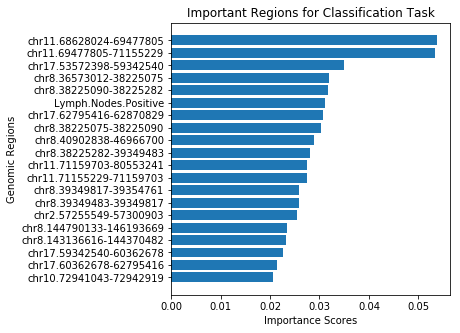

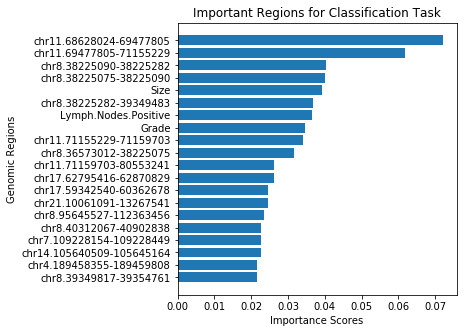

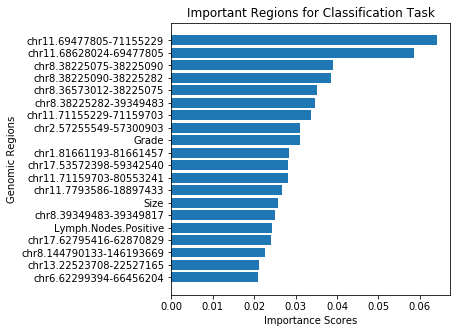

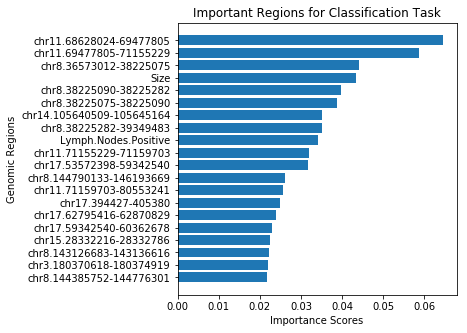

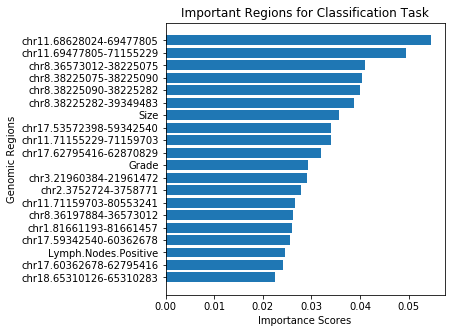

In [32]:
index = 0
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in cv.split(X, Y['label']):
    index += 1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    svc = SVC(kernel="linear", C=10)
    feature_names = X.columns
    svc.fit(X_train, Y_train['label'])
    coef = np.array(svc.coef_)[0]
    names = np.array(feature_names)
    #if index == 1:
    f_importances(coef, names)

## Principal Component Analysis

### Explained Variance

Number of Components: 1285
[4.13008731e-02 3.25615331e-02 2.64336527e-02 ... 4.33698001e-06
 4.30218660e-06 8.14516098e-33]


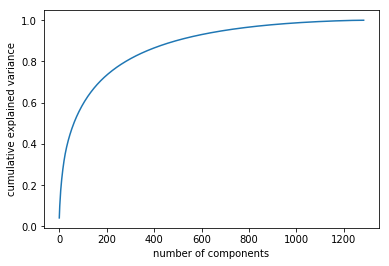

In [33]:
XX = X
XX = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA

pca = PCA().fit(XX)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

print("Number of Components: " + str(pca.n_components_))
print(pca.explained_variance_ratio_)

### PCA Plot

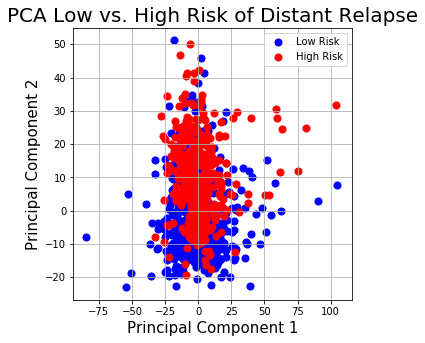

In [34]:
principalComponents = pca.transform(XX)
principalDf = pd.DataFrame(data = principalComponents[:,:2]
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, Y['label']], axis = 1)

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA Low vs. High Risk of Distant Relapse', fontsize = 20)
targets = [0,1]
colors = ['b','r','y','g']
legend = ['Low Risk', 'High Risk']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)

ax.legend(legend)
ax.grid()